# Topic modeling on PWDB textual data

## Importing libraries

In [50]:
# import sys
# sys.path.append("/home/jovyan/work/sem-covid/")
# sys.path = list(set(sys.path))
#
# import os
# os.getcwd()
# os.chdir('/home/jovyan/work/sem-covid/')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim
import pyLDAvis.gensim_models

from gensim.models import LdaModel, LsiModel
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud
from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_fix_unicode, \
    clean_remove_currency_symbols, clean_remove_emails, clean_remove_urls
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.token_management import filter_stop_words,\
    filter_pos, filter_stop_words_on_a_span_list, select_pos, spacy_stop_words

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Fetching data from document store

In [51]:
pwdb = Dataset.PWDB.fetch()

pwdb.fillna(value="", inplace=True)

document_corpus = pwdb['title'].map(str) + '. ' + \
                  pwdb['background_info_description'].map(str) + '. ' + \
                  pwdb['content_of_measure_description'].map(str) + '. ' + \
                  pwdb['use_of_measure_description'] + '. ' + \
                  pwdb['involvement_of_social_partners_description']

## Data preprocessing

- data cleanup
- turn corpus into spacy Docs

In [52]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                     "[", "]", "-", "_", "\r"]

document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)
document_corpus = document_corpus.apply(clean_fix_unicode)
document_corpus = document_corpus.apply(clean_remove_urls)
document_corpus = document_corpus.apply(clean_remove_emails)
document_corpus = document_corpus.apply(clean_remove_currency_symbols)
spacy_corpus = document_corpus.apply(nlp)

## Preparing few corpora

Filter document tokens. Select only the needed/interesting tokens for Topic modeling:
   - all words
   - nouns
   - verbs
   - noun phrases

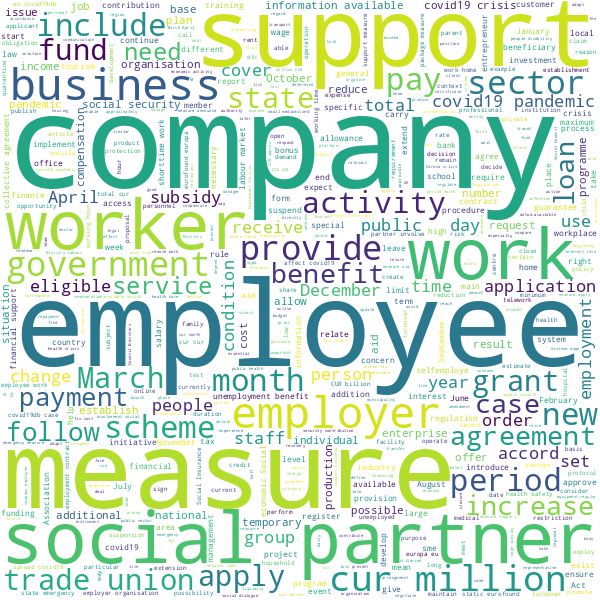

In [53]:
word_corpus = spacy_corpus.apply(filter_stop_words, stop_words=spacy_stop_words)
word_corpus = word_corpus.apply(filter_pos, pos="PUNCT")
word_corpus = word_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in word_corpus]) )

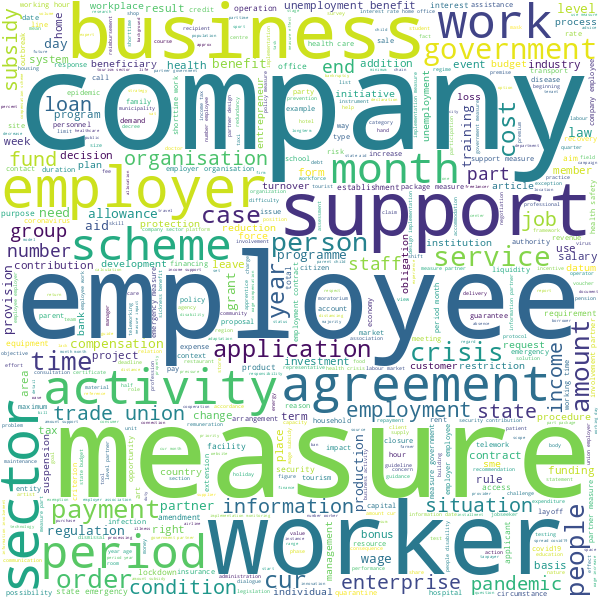

In [54]:
noun_corpus = spacy_corpus.apply(select_pos, pos="NOUN")
noun_corpus = noun_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_corpus]) )

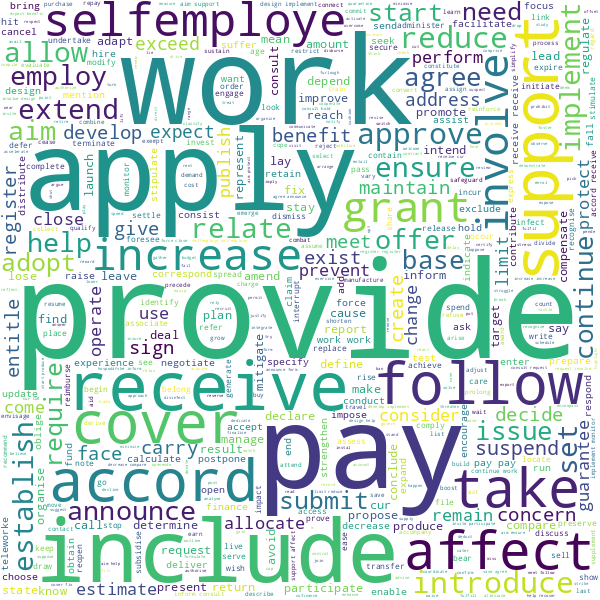

In [55]:
verb_corpus = spacy_corpus.apply(select_pos, pos="VERB")
verb_corpus = verb_corpus.apply(filter_stop_words)
verb_corpus = verb_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in verb_corpus]) )

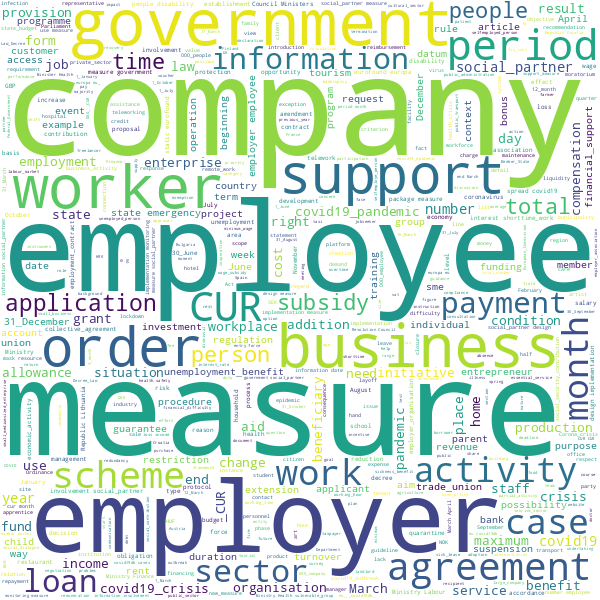

In [56]:
noun_phrase_corpus = spacy_corpus.apply(lambda x: x.noun_chunks)
noun_phrase_corpus = noun_phrase_corpus.apply(filter_stop_words_on_a_span_list)

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_phrase_corpus]) )

## Train LDA + LSI models

- create_dag a dictionary and a corpus with each corpora
- train LDA models
- train LSI models
- visualize the results (LDA)

In [57]:
word_dictionary = gensim.corpora.Dictionary(word_corpus)
noun_dictionary = gensim.corpora.Dictionary(noun_corpus)
verb_dictionary = gensim.corpora.Dictionary(verb_corpus)
noun_phrases_dictionary = gensim.corpora.Dictionary(noun_phrase_corpus)

word_gensim_corpus = [word_dictionary.doc2bow(docs) for docs in word_corpus]
noun_gensim_corpus = [noun_dictionary.doc2bow(docs) for docs in noun_corpus]
verb_gensim_corpus = [verb_dictionary.doc2bow(docs) for docs in verb_corpus]
noun_phrases_gensim_corpus = [noun_phrases_dictionary.doc2bow(docs) for docs in noun_phrase_corpus]

In [58]:
word_lda_model = LdaModel(corpus=word_gensim_corpus, num_topics=5, id2word=word_dictionary, chunksize=30, random_state=40)
noun_lda_model = LdaModel(corpus=noun_gensim_corpus, num_topics=5, id2word=noun_dictionary, chunksize=30, random_state=40)
verb_lda_model = LdaModel(corpus=verb_gensim_corpus, num_topics=4, id2word=verb_dictionary, chunksize=20, random_state=40)
noun_phrases_lda_model = LdaModel(corpus=noun_phrases_gensim_corpus, num_topics=5, id2word=noun_phrases_dictionary, chunksize=30, random_state=40)

word_lsa_model = LsiModel(corpus=word_gensim_corpus, num_topics=6, id2word=word_dictionary, chunksize=300)
noun_lsa_model = LsiModel(corpus=noun_gensim_corpus, num_topics=6, id2word=noun_dictionary, chunksize=300)
verb_lsa_model = LsiModel(corpus=verb_gensim_corpus, num_topics=6, id2word=verb_dictionary, chunksize=300)
noun_phrases_lsa_model = LsiModel(corpus=noun_phrases_gensim_corpus, num_topics=6, id2word=noun_phrases_dictionary, chunksize=300)

In [63]:
pyLDAvis.enable_notebook()
word_visualization = pyLDAvis.gensim_models.prepare(word_lda_model, word_gensim_corpus, word_dictionary)
word_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.130153 -0.140749       1        1  26.750624
2     -0.166570  0.090060       2        1  25.649502
3      0.089993  0.175276       3        1  23.740896
1      0.002377 -0.031532       4        1  12.814676
0      0.204353 -0.093055       5        1  11.044301, topic_info=               Term         Freq        Total Category  logprob  loglift
313               <  2396.000000  2396.000000  Default  30.0000  30.0000
97             work  2041.000000  2041.000000  Default  29.0000  29.0000
43         employee  2294.000000  2294.000000  Default  28.0000  28.0000
18        agreement  1010.000000  1010.000000  Default  27.0000  27.0000
363         million  1334.000000  1334.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
208         include   110.974012   713.974606   Topic5  -5.5620   0.3417
642  implementation   100.773460   268.851391   Topic5  -5.6584   1.2220
80           sector   111.109659  1567.710521   Topic5  -5.5607  -0.4436
358     involvement    99.480054   289.696286   Topic5  -5.6713   1.1344
606             aim    99.811630   450.027469   Topic5  -5.6680   0.6972

[397 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
101       1  0.067344          .
101       2  0.866498          .
101       3  0.058365          .
101       4  0.004490          .
382       1  0.895229       2019
...     ...       ...        ...
98        3  0.966062    working
310       3  0.993888  workplace
1857      4  0.960075   workshop
2190      5  0.957278      world
1996      4  0.962165      young

[892 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

In [64]:
noun_visualization = pyLDAvis.gensim_models.prepare(noun_lda_model, noun_gensim_corpus, noun_dictionary)
noun_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.063235  0.083807       1        1  34.254269
4      0.184093  0.052805       2        1  29.342433
0      0.162124 -0.136878       3        1  17.269127
2     -0.185145  0.184631       4        1  14.936507
1     -0.224307 -0.184364       5        1   4.197664, topic_info=          Term         Freq        Total Category  logprob  loglift
10    employee  2238.000000  2238.000000  Default  30.0000  30.0000
187     income   808.000000   808.000000  Default  29.0000  29.0000
11    employer  1331.000000  1331.000000  Default  28.0000  28.0000
111    payment   862.000000   862.000000  Default  27.0000  27.0000
140     worker  1470.000000  1470.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
88   infection    28.837635   136.320686   Topic5  -5.2117   1.6173
293  situation    32.249702   458.196938   Topic5  -5.0999   0.5169
391  passenger    24.745124    74.014666   Topic5  -5.3648   2.0750
177       case    29.266800   510.316496   Topic5  -5.1969   0.3121
80      health    28.199561   768.197630   Topic5  -5.2341  -0.1341

[340 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
42        1  0.059628         .
42        3  0.894415         .
42        5  0.043366         .
45        1  0.327937  activity
45        2  0.254951  activity
...     ...       ...       ...
41        2  0.399510      year
41        3  0.331153      year
41        4  0.094181      year
41        5  0.012152      year
231       5  0.969176   zmianie

[672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 3, 2])

In [65]:
verb_visualization = pyLDAvis.gensim_models.prepare(verb_lda_model, verb_gensim_corpus, verb_dictionary)
verb_visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.002170  0.060267       1        1  57.664063
0     -0.049882  0.220885       2        1  16.865854
1     -0.199474 -0.181521       3        1  12.856365
2      0.251526 -0.099631       4        1  12.613718, topic_info=            Term        Freq       Total Category  logprob  loglift
84   selfemploye  410.000000  410.000000  Default  30.0000  30.0000
57       receive  877.000000  877.000000  Default  29.0000  29.0000
137     announce  309.000000  309.000000  Default  28.0000  28.0000
145        offer  249.000000  249.000000  Default  27.0000  27.0000
72       approve  351.000000  351.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
135          aim   61.190154  309.507124   Topic4  -4.4965   0.4494
43       include   72.287401  727.889676   Topic4  -4.3298  -0.2391
158         face   45.554521  155.258103   Topic4  -4.7916   0.8442
54           pay   48.340963  951.522729   Topic4  -4.7322  -0.9094
28         carry   40.204226  167.150746   Topic4  -4.9165   0.6455

[248 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
306       1  0.095435     access
306       3  0.858917     access
208       2  0.987968  accompany
24        1  0.762136     accord
24        2  0.082927     accord
...     ...       ...        ...
176       2  0.981984       test
273       3  0.951843      think
22        1  0.902258       work
22        2  0.071941       work
22        4  0.024979       work

[373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

In [66]:
noun_phrases_visualization = pyLDAvis.gensim_models.prepare(noun_phrases_lda_model, noun_phrases_gensim_corpus, noun_phrases_dictionary)
noun_phrases_visualization


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.048780  0.179342       1        1  36.776266
1      0.138513  0.060364       2        1  18.190642
4     -0.093736 -0.061294       3        1  17.810157
2      0.134597 -0.108065       4        1  13.817159
3     -0.130594 -0.070347       5        1  13.405776, topic_info=          Term         Freq        Total Category  logprob  loglift
21    employee  1426.000000  1426.000000  Default  30.0000  30.0000
10   agreement   467.000000   467.000000  Default  29.0000  29.0000
937       loan   309.000000   309.000000  Default  28.0000  28.0000
12     company  1451.000000  1451.000000  Default  27.0000  27.0000
22    employer   853.000000   853.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
41      sector    69.279104   427.721871   Topic5  -5.4524   0.1892
216      total    56.999703   231.994898   Topic5  -5.6475   0.6058
713      month    58.871703   449.026222   Topic5  -5.6152  -0.0222
26        form    52.310092   163.075775   Topic5  -5.7334   0.8725
143    payment    51.607581   365.301730   Topic5  -5.7469   0.0524

[323 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1193      5  0.980395      15_April
425       5  0.991195       30_June
1530      5  0.960130  30_September
219       1  0.365809           Act
219       2  0.034295           Act
...     ...       ...           ...
55        1  0.339484          year
55        2  0.120462          year
55        3  0.416142          year
55        4  0.021902          year
55        5  0.102210          year

[553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])